# Import libraries and init

In [63]:
# import ROOT -- don't need this for now
import numpy as np
import pandas as pd
from collections import OrderedDict
import math
import time

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams.update({'font.size': 11})

import uproot # uproot needs to be last for some reason

In [2]:
uproot.__version__

'3.4.17'

In [3]:
pd.__version__

'0.24.2'

In [4]:
import sys
sys.version
sys.version_info

sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)

In [5]:
from functools import reduce
import operator

In [6]:
import multiprocessing
num_cores = multiprocessing.cpu_count()
num_cores

24

In [7]:
import concurrent.futures
executor = concurrent.futures.ThreadPoolExecutor(48)

# Load ntuples from analyzer

Define parameters in separate block so can change them without loading files all over again

In [8]:
masses = [('60p0','20p0'),('6p0','2p0'),('52p5','5p0'),('5p25','0p5')]
printMasses = lambda mass: f'({float(mass[0].replace("p","."))-float(mass[1].replace("p","."))/2}, ' + \
                                f'{float(mass[0].replace("p","."))+float(mass[1].replace("p","."))/2}) GeV'
mchis = dict([(mass[0], printMasses(mass)) for mass in masses])
# mchis = ['test2']
ctaus = [10]#, 10, 100, 1000]

numCuts = np.arange(0,6)
labels = [ f'cut{cut}' for cut in numCuts ]
cutDescriptions = ['cut1: MET/MHT trigger fired (120 GeV)', \
                   'cut2: j1 pT > 120 GeV, <= 2j w/ pT > 30 GeV', \
                   'cut3: mu1 pT > 5 GeV, 0.1 < |dxy| < 700 cm', \
                   'cut4: mu2 pT > 5 GeV, 0.1 < |dxy| < 700 cm', \
                   r'cut5: $|\Delta\Phi$(MET, mu pair)| < 0.4'
                  ]

branchPath = 'SREffi_dsa'
baseDir = '../Firefighter/washAOD/SROptimization/'
fileName = lambda Mchi, dMchi, ctau: baseDir + f'Mchi-{Mchi}_dMchi-{dMchi}_ctau-{ctau}.root'


(Re)initialize data containers

In [9]:
trees = OrderedDict({})
genInfo = OrderedDict({})
numEvents = OrderedDict({})

Load signal files

In [10]:
numParams = len(masses)*len(ctaus)
countParam = 1

for (Mchi, dMchi) in masses:
    countCtaus = 1
    trees[Mchi] = OrderedDict({})
    numEvents[Mchi] = OrderedDict({})
    genInfo[Mchi] = OrderedDict({})
    for ctau in ctaus:
        genInfo[Mchi][ctau] = uproot.open(fileName(Mchi, dMchi, ctau))['GEN/gen']#.pandas.df(flatten=False)
        trees[Mchi][ctau] = uproot.open(fileName(Mchi, dMchi, ctau))[branchPath + f'/cutsTree']#.pandas.df(flatten=False)
        print(f'{countParam} of {numParams}: ' + fileName(Mchi, dMchi, ctau))
        countParam += 1

1 of 4: ../Firefighter/washAOD/SROptimization/Mchi-60p0_dMchi-20p0_ctau-10.root
2 of 4: ../Firefighter/washAOD/SROptimization/Mchi-6p0_dMchi-2p0_ctau-10.root
3 of 4: ../Firefighter/washAOD/SROptimization/Mchi-52p5_dMchi-5p0_ctau-10.root
4 of 4: ../Firefighter/washAOD/SROptimization/Mchi-5p25_dMchi-0p5_ctau-10.root


Load background files

In [10]:
from XRootD import client
from XRootD.client.flags import DirListFlags, StatInfoFlags, OpenFlags, MkDirFlags, QueryCode
# import xrdfs_find

In [11]:
bkgs_dirs = ['DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/crab_DYJetsToLL/190325_184023/0000',
             'DYJetsToTauTau_ForcedMuDecay_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8/crab_DYJetsToTauTau/190325_183740/0000',
             'QCD_bEnriched_HT100to200_TuneCP5_13TeV-madgraph-pythia8/crab_QCD_bEnriched_HT100to200/190327_144913/0000',
             'TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/crab_TTTo2L2Nu/190325_190600/0000',
             'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/crab_WJetsToLNu_HT-100To200/190325_190137/0000',
             'WWJJToLNuLNu_QCD_noTop_13TeV-madgraph-pythia8/crab_WWJJToLNuLNu/190325_183506/0000',
             'WWTo2L2Nu_NNPDF31_TuneCP5_13TeV-powheg-pythia8/crab_WWTo2L2Nu_v3/190325_173808/0000',
             'WZTo3LNu_TuneCP5_13TeV-powheg-pythia8/crab_WZTo3LNu/190325_183610/0000',
             'ZJetsToNuNu_HT-100To200_13TeV-madgraph/crab_ZJetsToNuNu_HT-100To200/190325_190422/0000',
             'ZZTo2L2Nu_TuneCP5_13TeV_powheg_pythia8/crab_ZZTo2L2Nu/190325_182956/0000',
             
            ]
bkgs = ['DYJetsToLL', 'DYJetsToTauTau', 'QCD_bEnriched_HT100to200', 'TTTo2L2Nu', 'WJetsToLNu_HT-100To200', 
        'WWJJToLNuLNu', 'WWTo2L2Nu', 'WZTo3LNu', 'ZJetsToNuNu_HT-100To200', 'ZZTo2L2Nu']

In [12]:
xrdfs = client.FileSystem("root://cmseos.fnal.gov/")

redirector = 'root://cmsxrootd.fnal.gov'
bkg_base_dir = '/store/group/lpcmetx/iDM/Ntuples/2018/backgrounds'
files = {}

for bkg, bkg_dir in zip(bkgs, bkgs_dirs):
    files[bkg] = []
    status, listing = xrdfs.dirlist(f'{bkg_base_dir}/{bkg_dir}', DirListFlags.STAT)
    for file in listing:
        if '.root' in file.name:
            files[bkg].append(f'{redirector}/{bkg_base_dir}/{bkg_dir}/{file.name}')

In [68]:
pileup['DYJetsToTauTau']['genwgt'].value_counts()

 26331.201172    755452
-26331.201172    145064
Name: genwgt, dtype: int64

In [64]:
MAX_FILES = 5

dim1entries = ['recoPFMetPt', 'recoPFMetPhi', 'genputrue', 'genpuobs', 'genwgt', 'cutsVec*']
dimVertex =  ['recoDr', 'recoVxy', 'recoVz']
dimMu = ['recoPt', 'recoEta', 'recoPhi']
dimJet = ['recoPFJetPt', 'recoPFJetEta', 'recoPFJetPhi']

leadingJet = {}; MET = {};
muons = {}; vertex = {};
cuts = {}; cutsCrit = {}
pileup = {}

start = time.time()

for bkg in bkgs:

    MET[bkg] = []; vertex[bkg] = []
    cuts[bkg] = []; cutsCrit[bkg] = []
    pileup[bkg] = []
    for dfs in uproot.iterate(files[bkg][0:MAX_FILES], 'SREffi_dsa/cutsTree', dim1entries,
                              outputtype=pd.DataFrame, flatten=True, executor=executor):
        MET[bkg].append(dfs[['recoPFMetPt', 'recoPFMetPhi']])
        cuts[bkg].append(dfs[[f'cutsVec[{cut}]' for cut in numCuts]])
        try:
            pileup[bkg].append(dfs[['genputrue','genpuobs','genwgt']])
        except KeyError:
            print(f'Sample {mchi} does not have pileup or weight information')
    MET[bkg] = pd.concat(MET[bkg])
    cuts[bkg] = pd.concat(cuts[bkg])
    pileup[bkg] = pd.concat(pileup[bkg]) if len(pileup[bkg]) > 0 else []
    pileup[bkg]['relgenwgt'] = pileup[bkg]['genwgt']/pileup[bkg]['genwgt'].sum()
    cutsCrit[bkg] = [ cuts[bkg][f'cutsVec[{cut}]'] == 1 for cut in numCuts ]
    
    vertex[bkg] = []
    for dfs in uproot.iterate(files[bkg][0:MAX_FILES], 'SREffi_dsa/cutsTree', dimVertex,
                              outputtype=pd.DataFrame, flatten=True, executor=executor):
        vertex[bkg].append(dfs.reset_index(level=1))
    vertex[bkg] = pd.concat(vertex[bkg])
    
    muons[bkg] = []
    for dfs in uproot.iterate(files[bkg][0:MAX_FILES], 'SREffi_dsa/cutsTree', dimMu,
                              outputtype=pd.DataFrame, flatten=True, executor=executor):
        muons[bkg].append(dfs.reset_index(level=1))
    muons[bkg] = pd.concat(muons[bkg])
    
    leadingJet[bkg] = []
    for dfs in uproot.iterate(files[bkg][0:MAX_FILES], 'SREffi_dsa/cutsTree', dimJet, 
                              outputtype=pd.DataFrame, flatten=True, executor=executor):
        leadingJet[bkg].append(dfs.loc[(slice(None),0),slice(None)].reset_index(level=1))
    leadingJet[bkg] = pd.concat(leadingJet[bkg])

end = time.time()

print(f'Time elapsed: {end - start} seconds')

Time elapsed: 327.35303115844727 seconds


In [27]:
genwgt = pileup['TTTo2L2Nu']['genwgt']
genwgt.name

'genwgt'

In [42]:
cutsToApply = reduce(operator.and_, cutsCrit['TTTo2L2Nu'][0:0+1])
cutsToApply

entry
0         True
1         True
2         True
3         True
4         True
5         True
6         True
7         True
8         True
9         True
10        True
11        True
12        True
13        True
14        True
15        True
16        True
17        True
18        True
19        True
20        True
21        True
22        True
23        True
24        True
25        True
26        True
27        True
28        True
29        True
          ... 
774970    True
774971    True
774972    True
774973    True
774974    True
774975    True
774976    True
774977    True
774978    True
774979    True
774980    True
774981    True
774982    True
774983    True
774984    True
774985    True
774986    True
774987    True
774988    True
774989    True
774990    True
774991    True
774992    True
774993    True
774994    True
774995    True
774996    True
774997    True
774998    True
774999    True
Name: cutsVec[0], Length: 775000, dtype: bool

In [62]:
muons['TTTo2L2Nu']#[cutsToApply].groupby('entry').ngroups

,subentry,recoPt,recoEta,recoPhi
entry,,,,
1,0,3.312279,1.270452,-0.901354
2,0,12.544751,1.742029,-1.316728
2,1,6.866735,-1.081798,-2.877556
3,0,2.938355,0.560862,-0.030996
3,1,1.933983,-2.162859,-2.269309
4,0,58.646614,1.102810,-1.207376
4,1,57.876324,-0.186169,0.273987
5,0,32.914200,-0.231821,2.226732
5,1,3.957509,0.655122,1.312016


In [50]:
tempDf = pd.concat([muons['TTTo2L2Nu']['recoPt'].groupby('entry').nth(0), genwgt], axis=1).dropna()
tempDf

,recoPt,genwgt
entry,,
1,3.312279,1.0
2,12.544751,1.0
3,2.938355,1.0
4,58.646614,1.0
5,32.914200,1.0
6,57.173203,1.0
7,10.403080,1.0
9,26.117432,1.0
11,12.950257,1.0


In [58]:
np.histogram(tempDf[cutsToApply]['recoPt'], bins=60, range=(0,60), weights=tempDf[cutsToApply]['genwgt'])[0].sum()

/cvmfs/cms-lpc.opensciencegrid.org/sl7/gpu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


506576.0

In [44]:
muons['TTTo2L2Nu'][cutsToApply]['recoPt'].groupby('entry').nth(0)

/cvmfs/cms-lpc.opensciencegrid.org/sl7/gpu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


entry
1           3.312279
2          12.544751
3           2.938355
4          58.646614
5          32.914200
6          57.173203
7          10.403080
9          26.117432
11         12.950257
12         32.123562
14         42.813057
15         76.727272
16        100.189621
17         30.016823
18         24.686619
19         39.095867
20         20.789545
21          1.563958
22         27.887970
23         50.583786
25          6.870414
26         82.452133
27         15.585767
28          3.629993
29          1.732918
30          7.713550
31         40.172119
32        146.522217
34         51.928379
35         16.506252
             ...    
774964      4.290947
774965     13.564469
774966     17.644522
774967     76.515221
774969      9.600477
774970     64.514801
774971     14.715742
774972    173.842819
774973     20.430244
774974     52.745029
774975      2.840552
774976     22.686092
774977      4.429549
774978     24.509892
774980      2.644737
774981     24.984350
774982 

In [61]:
MET['TTTo2L2Nu']

,recoPFMetPt,recoPFMetPhi
entry,,
0,95.662201,-0.700726
1,63.085754,-0.168939
2,203.974701,0.593792
3,109.777069,0.588479
4,65.759552,-1.600541
5,27.910362,-0.333041
6,76.892746,0.857925
7,41.756649,-2.958356
8,76.656792,1.998360


In [15]:
for bkg in bkgs:
    MET[bkg].info(memory_usage='deep')
    muons[bkg].info(memory_usage='deep')
    vertex[bkg].info(memory_usage='deep')
    cuts[bkg].info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522947 entries, 0 to 522946
Data columns (total 2 columns):
recoPFMetPt     522947 non-null float32
recoPFMetPhi    522947 non-null float32
dtypes: float32(2)
memory usage: 4.0 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 502136 entries, 0 to 522946
Data columns (total 4 columns):
subentry    502136 non-null int64
recoPt      502136 non-null float32
recoEta     502136 non-null float32
recoPhi     502136 non-null float32
dtypes: float32(3), int64(1)
memory usage: 13.4 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 170231 entries, 0 to 522945
Data columns (total 4 columns):
subentry    170231 non-null int64
recoDr      170231 non-null float32
recoVxy     170231 non-null float32
recoVz      170231 non-null float32
dtypes: float32(3), int64(1)
memory usage: 4.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522947 entries, 0 to 522946
Data columns (total 6 columns):
cutsVec[0]    522947 non-null uint32
cutsVec[1]    5229

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474734 entries, 0 to 777284
Data columns (total 4 columns):
subentry    474734 non-null int64
recoPt      474734 non-null float32
recoEta     474734 non-null float32
recoPhi     474734 non-null float32
dtypes: float32(3), int64(1)
memory usage: 12.7 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 110544 entries, 8 to 777284
Data columns (total 4 columns):
subentry    110544 non-null int64
recoDr      110544 non-null float32
recoVxy     110544 non-null float32
recoVz      110544 non-null float32
dtypes: float32(3), int64(1)
memory usage: 3.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777286 entries, 0 to 777285
Data columns (total 6 columns):
cutsVec[0]    777286 non-null uint32
cutsVec[1]    777286 non-null uint32
cutsVec[2]    777286 non-null uint32
cutsVec[3]    777286 non-null uint32
cutsVec[4]    777286 non-null uint32
cutsVec[5]    777286 non-null uint32
dtypes: uint32(6)
memory usage: 17.8 MB
<class 'pandas.core.fra

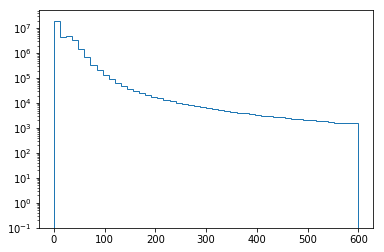

In [24]:
plt.hist(muons['DYJetsToLL']['recoPt'],bins=50,histtype='step', log=True,range=(0,600));

In [91]:
trees['test2'] = uproot.open('root://cmsxrootd.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/backgrounds/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/crab_DYJetsToLL/190325_184023/0000/output_99.root')['SREffi_dsa/cutsTree']

In [7]:
# dfs['QCD_bEnriched_HT500to700'] = uproot.open('root://cmsxrootd.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/backgrounds/QCD_bEnriched_HT500to700_TuneCP5_13TeV-madgraph-pythia8/Mchi-60p0_dMchi-20p0_ctau-1.root')['SREffi_dsa/cutsTree'].pandas.df()
# dfs['DYJetsToLL'] = uproot.open('/tmp/as2872/DYJetsToLL.root')['SREffi_dsa/cutsTree'].pandas.df()
# dfs['ZJetsToNuNu'] = uproot.open('/tmp/as2872/ZJetsToNuNu.root')['SREffi_dsa/cutsTree'].pandas.df()
trees['ZJetsToNuNu'] = uproot.open('root://cmsxrootd.fnal.gov//store/group/lpcmetx/iDM/Ntuples/2018/backgrounds/ZJetsToNuNu.root')['SREffi_dsa/cutsTree']#.pandas.df(flatten=False)

Create pandas dataframes for different physics objects now that uproot won't flatten them anymore
(does make code faster)

In [222]:
# leadingJet = OrderedDict({}); MET = OrderedDict({});
# muons = OrderedDict({}); vertex = OrderedDict({});
# cuts = OrderedDict({}); cutsCrit = OrderedDict({})
# pileup = OrderedDict({})

for mchi in mchis:
    leadingJet[mchi] = trees[mchi][10].pandas.df(['recoPFJetPt','recoPFJetEta','recoPFJetPhi']).loc[(slice(None),0),slice(None)].reset_index(level=1)
    MET[mchi] = trees[mchi][10].pandas.df(['recoPFMetPt', 'recoPFMetPhi'])#.reset_index(level=1)
    muons[mchi] = trees[mchi][10].pandas.df(['recoPt','recoEta','recoPhi','recoDxy','recoDz']).reset_index(level=1)
    vertex[mchi] = trees[mchi][10].pandas.df(['recoDr','recoVxy','recoVz']).reset_index(level=1)
    cuts[mchi] = trees[mchi][10].pandas.df('cutsVec*')
    cutsCrit[mchi] = [ cuts[mchi][f'cutsVec[{cut}]'] == 1 for cut in numCuts ]
    try:
        pileup[mchi] = trees[mchi][10].pandas.df(['genputrue','genpuobs','genwgt'])
        pileup[mchi]['relgenwgt'] = pileup[mchi]['genwgt']/pileup[mchi]['genwgt'].sum()
    except KeyError:
        print(f'Sample {mchi} does not have pileup or weight information')

Sample 60p0 does not have pileup or weight information
Sample 6p0 does not have pileup or weight information
Sample 52p5 does not have pileup or weight information
Sample 5p25 does not have pileup or weight information


Separately calculate the phi average angle between the two muons -- for use in DeltaPhi(MET, muon pair) -- since it takes a while

In [111]:
def parallelize(data, func):
#     data_split = np.array_split(data, partitions)
    pool = multiprocessing.Pool(num_cores/2)
#     data = pd.concat(pool.map(func, data_split))
    data = pd.concat(pool.map(func, [group for name, group in data]))
    pool.close()
    pool.join()
    return data

In [101]:
# Helper function to calculate average angles
# This takes a few seconds to run, since we 
# are using the apply method
def calcAvgAngle(group):
    x = np.cos(group['recoPhi'].iloc[0]) + np.cos(group['recoPhi'].iloc[-1])
    y = np.sin(group['recoPhi'].iloc[0]) + np.sin(group['recoPhi'].iloc[-1])
    return math.atan2(y/2, x/2)

def func_group_apply(df):
    return df.groupby('entry').apply(calcAvgAngle)

avgMuonAngle = OrderedDict({})
# for mchi in mchis:
#     avgMuonAngle[mchi] = muons[mchi].groupby('entry').apply(calcAvgAngle)

# for bkg in bkgs:
#     avgMuonAngle[bkg] = parallelize(muons[bkg].groupby('entry'), calcAvgAngle)

for bkg in bkgs:
    muons[bkg] = muons[bkg].reset_index()
    muons[bkg]['data_chunk'] = muons[bkg]['entry'].mod(num_cores * 3 / 2) # num_cores/2 * 3 chunks/core
    muons[bkg] = muons[bkg].set_index(['entry'])
    
    avgMuonAngle[bkg] = parallelize(muons[bkg].groupby('data_chunk'), func_group_apply)

# Pileup distributions

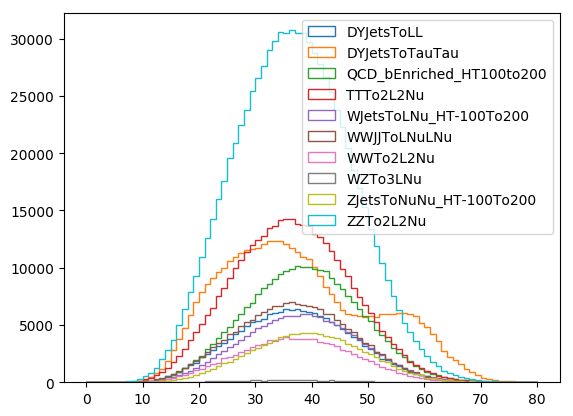

In [173]:
# for mchi in mchis:
#     plt.hist(pileup[mchi]['genputrue'],bins=80,range=(0,80),histtype='step');
for bkg in bkgs:
    plt.hist(pileup[bkg]['genputrue'],bins=80,range=(0,80),histtype='step', label=bkg)
plt.legend();

# Inclusive cuts

In [174]:
cutFlowDict = OrderedDict()
# for mchi in mchis:
#     cutFlowDict[mchi] = []
#     for cut in numCuts:
#         cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
#         cutFlowDict[mchi].append(len(cuts[mchi][cutsToApply]))
for bkg in bkgs:
    cutFlowDict[bkg] = []
    for cut in numCuts:
        cutsToApply = reduce(operator.and_, cutsCrit[bkg][0:cut+1])
        cutFlowDict[bkg].append(len(cuts[bkg][cutsToApply]))
        
cutFlowInclDf = pd.DataFrame.from_dict(cutFlowDict)
cutFlowInclDf

,DYJetsToLL,DYJetsToTauTau,QCD_bEnriched_HT100to200,TTTo2L2Nu,WJetsToLNu_HT-100To200,WWJJToLNuLNu,WWTo2L2Nu,WZTo3LNu,ZJetsToNuNu_HT-100To200,ZZTo2L2Nu
0,170231,403054,263080,379869,156155,184464,102807,4799,110544,829365
1,71,1096,0,24222,2605,24971,2862,83,5892,26603
2,2,154,0,483,973,1066,351,9,2581,3379
3,2,134,0,382,610,826,270,5,602,1703
4,0,69,0,158,68,256,79,1,48,646
5,0,40,0,13,11,43,12,0,2,64


In [218]:
[(bkg, len(files[bkg])) for bkg in bkgs]

[('DYJetsToLL', 490),
 ('DYJetsToTauTau', 2),
 ('QCD_bEnriched_HT100to200', 82),
 ('TTTo2L2Nu', 172),
 ('WJetsToLNu_HT-100To200', 66),
 ('WWJJToLNuLNu', 1),
 ('WWTo2L2Nu', 20),
 ('WZTo3LNu', 1),
 ('ZJetsToNuNu_HT-100To200', 54),
 ('ZZTo2L2Nu', 16)]

In [53]:
bkg = 'ZJetsToNuNu'
cutFlowDict[bkg] = []
cutsCrit = [ dfs[bkg][f'cutsVec[{cut}]']==1 for cut in cuts ]
for cut in cuts:
    cutsToApply = reduce(operator.and_, cutsCrit[0:cut+1])
    cutFlowDict[bkg].append(len(dfs[bkg][cutsToApply]))

In [55]:
print(cutFlowDict['QCD_bEnriched_HT500to700'])
print(cutFlowDict['DYJetsToLL'])
print(cutFlowDict['ZJetsToNuNu'])

[132636, 752, 103, 46, 9, 7]
[271207, 94, 18, 7, 1, 0]
[260268, 14466, 7436, 460, 29, 2]


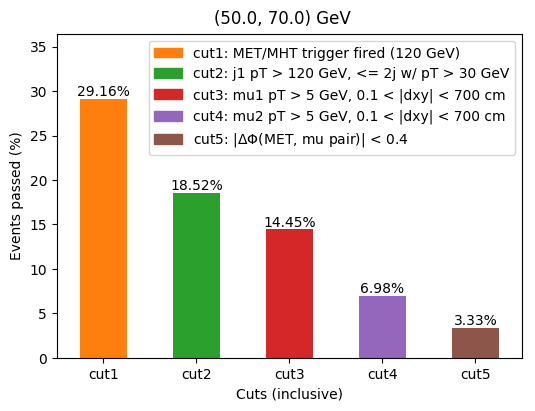

In [31]:
mchi = '60p0'
fig, axes = plt.subplots(1,1, figsize=(6,4))
fig.suptitle(f'{mchis[mchi]}')
fig.subplots_adjust(top=0.92)

# Histogram cut-flow of passing events
axlabels = [ f'cut{cut}' for cut in numCuts ]
data = 100 * cutFlowInclDf[mchi][1:] / cutFlowInclDf[mchi][0]
data.plot(ax=axes, kind='bar', color=['C1','C2','C3','C4','C5'])
axes.set_xlabel('Cuts (inclusive)')
axes.set_ylabel('Events passed (%)')
axes.set_xticklabels(axlabels[1:], rotation=0)
axes.set_xticks(np.arange(0,5))
axes.set_ylim(0, 1.25*max(data))

# Make bar labels
rects = axes.patches
barlabels = ["%.2f%%" % data[i] for i in np.arange(1,len(rects)+1)]
for rect, label in zip(rects, barlabels):
    height = rect.get_height()
    axes.text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom')

# Make legend
import matplotlib.patches as mpatches
patches = [ mpatches.Patch(color=f'C{c}', label=cutDescriptions[c-1]) for c in np.arange(1,6) ]
axes.legend(handles=patches)#, fontsize='small');

# Exclusive cuts

In [350]:
cutFlowDict = OrderedDict()
for mchi in mchis:
    cutFlowDict[mchi] = []
    for cut in numCuts:
        cutsToApply = cutsCrit[mchi][cut]
        cutFlowDict[mchi].append(len(cuts[mchi][cutsToApply]))
        
cutFlowExclDf = pd.DataFrame.from_dict(cutFlowDict)
cutFlowExclDf

,60p0,6p0,52p5,5p25
0,73968,23622,85517,30655
1,21571,4681,27116,5806
2,28861,8132,33789,10281
3,58544,13955,32446,6036
4,28538,3931,6231,733
5,14902,9360,11031,4680


# Plot everything together

To plot individual plots separately, copy relevant block of code and replace "axes[i,j]" with "plt", and take note that some of the functions change name, e.g. axes[i,j].set_xlabel() --> plt.xlabel() and axes[i,j].set_ylim() --> plt.ylim().

The other option is to copy the block and add "fig, ax = plt.subplots(1,1)" at the top, and then do the replacement axes[i,j] --> ax elsewhere.

## Helper functions

In [107]:
insets = False
log = True
histtype ='step'
iheight="65%"
iwidth="45%"

def plot_inset(data, axis, kwargs={}):
    if 'bins' not in kwargs: kwargs['bins'] = 10
    if 'histtype' not in kwargs: kwargs['histtype'] = build
    if insets:
        axins = inset_axes(axis, width=iwidth, height=iheight)
        for (cut,datum) in enumerate(data):
            ret = axins.hist(datum, **kwargs)
            if cut == 1:
                axins.set_ylim(0,1.1*max(ret[0]))
        return axins

def plot_full(data, axis, kwargs={}, labels = []):
    if 'bins' not in kwargs: kwargs['bins'] = 50
    if 'histtype' not in kwargs: kwargs['histtype'] = histtype
    if 'log' not in kwargs: kwargs['log'] = log
    for (cut,datum) in enumerate(data):
        ret = axis.hist(datum, label=(labels[cut] if len(labels) > 0 else ''), **kwargs)
        if cut == 0:
            axis.set_ylim(1, 1.5*max(ret[0]))
            
# Helper function to normalize angle differences to [-Pi, Pi]
# cond: if abs(phidiff) > Pi => phidiff = phidiff - 2*Pi*sign(phidiff)
def reducephi(row):
    if abs(row) > math.pi:
        return row - 2*math.pi*(row/abs(row))
    return row

## Plot MET and jet variables

In [132]:
bkg_grps = {'diboson':['WWJJToLNuLNu','WWTo2L2Nu','WZTo3LNu','ZZTo2L2Nu'], 
            'VJets':['WJetsToLNu_HT-100To200','ZJetsToNuNu_HT-100To200'],
            'ttbar':['TTTo2L2Nu'],
            'QCD': ['QCD_bEnriched_HT100to200'],
            'DY':['DYJetsToLL','DYJetsToTauTau']}

In [276]:
counts = {}
edges = {}
for grp in bkg_grps:
    for bkg in bkg_grps[grp]:
#         temp = pd.concat([leadingJet[bkg]['recoPFJetPt'], pileup[bkg]['genwgt']],axis=1).dropna()
#         count, edge = np.histogram(temp['recoPFJetPt'], bins=50, range=(0,1000), weights=temp['genwgt'])

#         angle = (MET[bkg]['recoPFMetPhi'] - leadingJet[bkg]['recoPFJetPhi']).dropna()
#         reducedAngle = angle.apply(reducephi)
#         temp = pd.concat([reducedAngle,pileup[bkg]['genwgt']],axis=1).dropna()

#         angleDiff = (MET[bkg]['recoPFMetPhi'].dropna() - avgMuonAngle[bkg]).dropna()
#         reducedAngleDiff = angleDiff.apply(reducephi).dropna()
#         temp = pd.concat([reducedAngleDiff, pileup[bkg]['genwgt']],axis=1).dropna()
        
#         temp = pd.concat([muons[bkg]['recoPt'].groupby('entry').nth(1), pileup[bkg]['genwgt']],axis=1).dropna()
        
#         temp = pd.concat([vertex[bkg]['recoDr'], pileup[bkg]['genwgt']],axis=1).dropna()
        
        temp = pd.concat([np.sqrt(vertex[bkg]['recoVxy']**2 + vertex[bkg]['recoVz']**2), \
                          pileup[bkg]['genwgt']],axis=1).dropna()
        
        count, edge = np.histogram(temp[0], bins=50, weights=temp['genwgt'])
        if grp not in counts:
            counts[grp] = count
            edges[grp] = edge
        else:
            counts[grp] += count

In [187]:
def plot_binned_data(axes, binedges, data, *args, **kwargs):
    #The dataset values are the bin centres
    x = (binedges[1:] + binedges[:-1]) / 2.0
    #The weights are the y-values of the input binned data
    weights = data
    return axes.hist(x, bins=binedges, weights=weights, *args, **kwargs)

(array([4.03511e+05, 5.87399e+05, 2.97016e+05, 9.77040e+04, 2.65070e+04,
        7.03600e+03, 2.32500e+03, 9.09000e+02, 4.41000e+02, 2.49000e+02,
        1.26000e+02, 8.60000e+01, 4.30000e+01, 3.30000e+01, 2.70000e+01,
        1.30000e+01, 7.00000e+00, 6.00000e+00, 4.00000e+00, 6.00000e+00,
        5.00000e+00, 3.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([   0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,
         180.,  200.,  220.,  240.,  260.,  280.,  300.,  320.,  340.,
         360.,  380.,  400.,  420.,  440.,  460.,  480.,  500.,  520.,
         540.,  560.,  580.,  600.,  620.,  640.,  660.

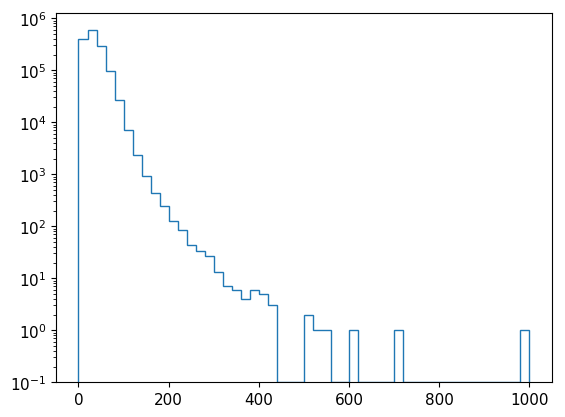

In [190]:
plot_binned_data(plt, edges['DY'], counts['DY'], histtype='step', log=True)

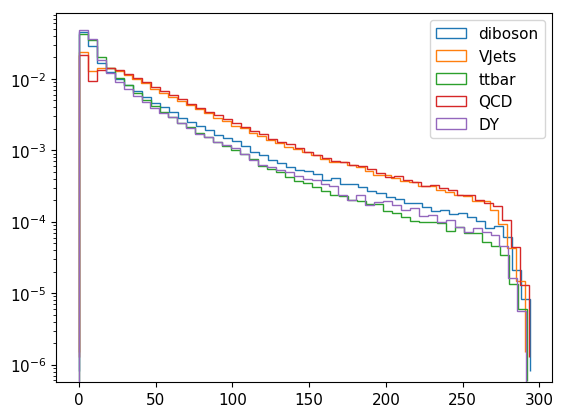

In [277]:
for grp in counts:
    plot_binned_data(plt, edges[grp], counts[grp], histtype='step', log=True, density=True,label=grp)
# plt.ylim([10**-7,10**-1])
plt.legend()

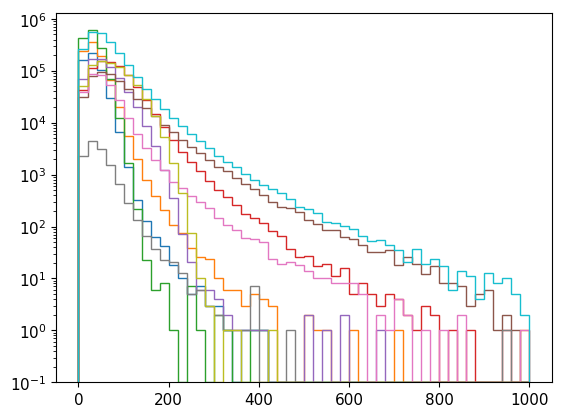

In [153]:
# for mchi in mchis:
#     plt.hist(MET[mchi]['recoPFMetPt'],bins=50,log=True, density=True, range=(0,1000),histtype='step')

for bkg in bkgs:
    plt.hist(MET[bkg]['recoPFMetPt'],bins=50,log=True, range=(0,1000),histtype='step')#, ls='--')
# plt.ylim([1,10**6])

/cvmfs/cms-lpc.opensciencegrid.org/sl7/gpu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/cvmfs/cms-lpc.opensciencegrid.org/sl7/gpu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


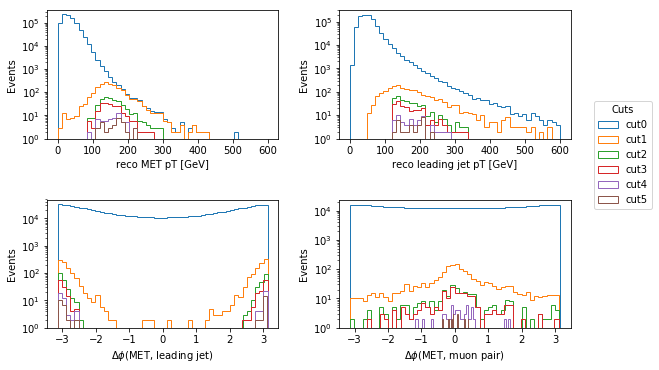

In [108]:
# mchi = '52p5'
mchi = 'DYJetsToTauTau'

### Make subplot axes
fig, axes = plt.subplots(2,2, figsize=(8,5))
plt.tight_layout(h_pad=4.0, w_pad=3.0)
for row in axes:
    for col in row:
        col.set_ylabel('Events')
        
# fig.suptitle(f'MET/jet Signal Region efficiency for {mchis[mchi]}')
# fig.subplots_adjust(top=0.92)

    
### reco MET pT
axes[0,0].set_xlabel('reco MET pT [GeV]')
data = []
for cut in numCuts:
    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
    data.append(MET[mchi][cutsToApply]['recoPFMetPt'])
plot_full(data, axes[0,0], dict({'range':(0,600)}))


### reco leading jet pT
axes[0,1].set_xlabel('reco leading jet pT [GeV]')
data = []
for cut in numCuts:
    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
    data.append(leadingJet[mchi][cutsToApply]['recoPFJetPt'])
plot_full(data, axes[0,1], dict({'range':(0,600)}), labels=labels)


### reco deltaPhi(MET, jet)
axes[1,0].set_xlabel(r'$\Delta\phi$(MET, leading jet)')
data = []
for cut in numCuts:
    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
    angle = MET[mchi][cutsToApply]['recoPFMetPhi'] - leadingJet[mchi][cutsToApply]['recoPFJetPhi']
    reducedAngle = angle.apply(reducephi)
    data.append(reducedAngle.dropna())
plot_full(data, axes[1,0])



### DeltaPhi b/w MET and muon pair
axes[1,1].set_xlabel(r'$\Delta\phi$(MET, muon pair)')
data = []
for cut in numCuts:
    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
    angleDiff = (MET[mchi][cutsToApply]['recoPFMetPhi'].dropna() - avgMuonAngle[mchi]).dropna()
    reducedAngleDiff = angleDiff.apply(reducephi).dropna()
    data.append(reducedAngleDiff)
plot_full(data, axes[1,1])

    
### Make and place legend w.r.t. axis[0,1] (upper right)
axes[0,1].legend(loc=(1.1,-0.55), title='Cuts');

## Plot muon variables

/cvmfs/cms-lpc.opensciencegrid.org/sl7/gpu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/cvmfs/cms-lpc.opensciencegrid.org/sl7/gpu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/cvmfs/cms-lpc.opensciencegrid.org/sl7/gpu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/cvmfs/cms-lpc.opensciencegrid.org/sl7/gpu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
No handles with labels found to put in legend.


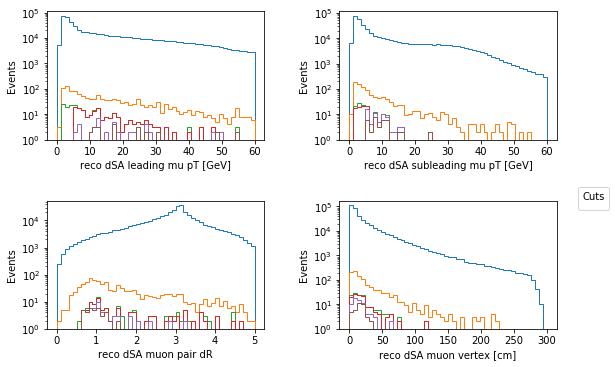

In [109]:
# mchi = '52p5'
mchi = 'DYJetsToTauTau'

### Make subplot axes
fig, axes = plt.subplots(2,2, figsize=(8,5))
for row in axes:
    for col in row:
        col.set_ylabel('Events')
plt.tight_layout(h_pad=4.0, w_pad=3.0)

# fig.suptitle(f'Muon Signal Region efficiency for {mchis[mchi]}')
# fig.subplots_adjust(top=0.92)


### reco dSA leading muon pT
axes[0,0].set_xlabel('reco dSA leading mu pT [GeV]')
# data = [dfs[mchi][10][cut].query('subentry==0')['recoPt'].dropna() for cut in cuts]
data = []
for cut in numCuts:
    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
    data.append(muons[mchi][cutsToApply]['recoPt'].groupby('entry').nth(0))
plot_full(data, axes[0,0], dict({'range':(0,60)}))


### reco dSA subleading muon pT
axes[0,1].set_xlabel('reco dSA subleading mu pT [GeV]')
data = []
for cut in numCuts:
    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
    data.append(muons[mchi][cutsToApply]['recoPt'].groupby('entry').nth(1))
plot_full(data, axes[0,1], dict({'range':(0,60)}))#, labels=labels)


### muon deltaR
axes[1,0].set_xlabel('reco dSA muon pair dR')
data = []
for cut in numCuts:
    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
    data.append(vertex[mchi][cutsToApply]['recoDr'])
plot_full(data, axes[1,0], dict({'range':(0,5)}))


### muon vertex
axes[1,1].set_xlabel('reco dSA muon vertex [cm]')
data = []
for cut in numCuts:
    cutsToApply = reduce(operator.and_, cutsCrit[mchi][0:cut+1])
    data.append(np.sqrt(vertex[mchi][cutsToApply]['recoVxy']**2 + vertex[mchi][cutsToApply]['recoVz']**2))
plot_full(data, axes[1,1], dict({'range':(0,300)}))


### Make and place legend w.r.t. axis[0,1] (upper right)
axes[0,1].legend(loc=(1.1,-0.55), title='Cuts');

In [ ]:
# Backup for previous way of calculating subleading muon pT and leading muon d0

# ### reco dSA subleading muon pT
# axes[0,1].set_xlabel('reco dSA subleading mu pT [GeV]')
# data = []
# for cut in cuts:
#     cutsToApply = reduce(operator.and_, cutsCrit[0:cut+1]).reset_index()
#     cutsToApply.columns = ['entry', 'subentry', 'cutsResult']
#     accptdEntries = cutsToApply.reset_index().loc[cutsToApply.reset_index()['cutsResult'] == True]['entry']

#     data.append(dfs[mchi].reset_index().loc[ dfs[mchi].reset_index()['entry'].isin(accptdEntries) & \
#                                        dfs[mchi].reset_index()['subentry'].isin([1]) ]['recoPt'].dropna())
    
# # labels = [f'cut{cut}' for cut in np.arange(0,6)]
# # plot_full(data, axes[0,1], dict({'range':(0,60)}), labels=labels)

# ### muon d0 (leading)
# axes[1,1].set_xlabel('reco dSA leading mu d0 [cm]')
# data = []
# for cut in cuts:
#     cutsToApply = reduce(operator.and_, cutsCrit[0:cut+1])
#     data.append(np.sqrt(dfs[mchi][10][cutsToApply].query('subentry==0')['recoDz'].dropna()**2 + \
#                 dfs[mchi][10][cutsToApply].query('subentry==0')['recoDxy'].dropna()**2))
# plot_full(data, axes[1,1], dict({'range':(0,300)}))

# Scratch tests and comparisons

Comparing results before and after fixing Dxy acceptance (i.e. Dxy is a signed distance and can be < 0)

In [200]:
testdfs = uproot.open("../Firefighter/washAOD/SROptimization/beforeFixingDxy/Mchi-60p0_dMchi-20p0_ctau-10.root")['SREffi_dsa' + f'/cutsTree'].pandas.df()

In [98]:
testdf2 = uproot.open("../Firefighter/washAOD/SROptimization/Mchi-60p0_dMchi-20p0_ctau-10.root")['SREffi_dsa' + f'/cutsTree'].pandas.df()

First block is for number of leading muons, second block for subleading, and third block for vertex

In [99]:
# Total number of events
print(len(testdf2.query('subentry==0')['recoPt']))
# Total number of leading muons reconstructed
print(len(testdf2.query('subentry==0')['recoPt'].dropna()))
# Total number of leading muons reconstructed with at least 5 GeV pT
print(len(testdf2.query('subentry==0')[['recoPt']].query('recoPt>5')))
print()
# Same for subleading muons
print(len(testdf2.query('subentry==1')[['recoPt']]))
print(len(testdf2.query('subentry==1')[['recoPt']].dropna()))
print(len(testdf2.query('subentry==1')[['recoPt']].query('recoPt>5')))
print()
# Number of events total, and number of events with vertex info
# Note this number is the same as number of subleading muons reconstructed
# So we have a vertex every time two muons are reconstructed
print(len(testdf2.query('subentry==0')[['recoVxy']]))
print(len(testdf2.query('subentry==0')[['recoVxy']].dropna()))

73968
65532
59393

73627
44229
29825

73968
44229


In [101]:
# Comparison for subleading muons, here we are 'emulating' the cut that I'm suspicious about.
# Goal is to find out which cut of the subleading muons is the most restrictive.

# All events
print(len(testdf2.query('subentry==1')[['recoPt','recoDxy']]))
# Events with subleading muon reconstructed
print(len(testdf2.query('subentry==1')[['recoPt','recoDxy']].dropna()))
# Now require at least 5 GeV pT
print(len(testdf2.query('subentry==1')[['recoPt','recoDxy']].loc[ testdf2.recoPt > 5 ]))
# Further require dxy to be between 0.1 and 700 cm as in the Analyzer cut
print(len(testdf2.query('subentry==1')[['recoPt','recoDxy']].loc[(testdf2.recoPt > 5) & (0.1 < testdf2.recoDxy.abs()) & (700 > testdf2.recoDxy.abs())]))
# The difference between the exclusive cut4 number reported in the table above and the final number here in
# this block is due solely to the "vertex valid" requirement, 29532 - 28538 = 994. Only 994 events are
# excluded due to invalid vertex reconstruction (but this if for (50, 70) GeV masses)

73627
44229
29825
29532


Old inclusive cutflow to highlight the increased signal efficiency after fixing the dxy treatment (compare with inclusive cutflow table above).

611 vs 2463 for (50, 70) GeV (x4 difference)

In [201]:
mchi='60p0'
cutFlowDict = OrderedDict()
# for mchi in ['5p25','6p0','52p5','60']:
cutFlowDict[mchi] = []
cutsCrit = [ testdfs[f'cutsVec[{cut}]']==1 for cut in cuts ]
for cut in cuts:
    cutsToApply = reduce(operator.and_, cutsCrit[0:cut+1])
    cutFlowDict[mchi].append(len(testdfs[cutsToApply]))
        
cutFlowDf = pd.DataFrame.from_dict(cutFlowDict)
cutFlowDf

,60p0
0,73968
1,21571
2,13698
3,5186
4,1262
5,611


Old exclusive cutflow to highlight the increased signal efficiency after fixing the dxy treatment (compare with exclusive cutflow table above)

Basiclly a factor of x2 in the exclusive cuts 3 and 4 (muon-related cuts). The factor is different in the inclusive cutflow (i.e. better) because a lot of the recovered events will pass other cuts as well.

In [104]:
mchi = '60p0'
cutFlowDict = OrderedDict()
# for mchi in ['5p25','6p0','52p5','60']:
cutFlowDict[mchi] = []
cutsCrit = [ testdfs[f'cutsVec[{cut}]']==1 for cut in np.arange(0,6) ]
for cut in np.arange(0,6):
    cutsToApply = cutsCrit[cut]
    cutFlowDict[mchi].append(len(testdfs[cutsToApply]))
        
cutFlowDf = pd.DataFrame.from_dict(cutFlowDict)
cutFlowDf

,60p0
0,73968
1,21571
2,28861
3,29044
4,14268
5,14902


In [87]:
photongun36 = uproot.open('/uscms/homes/a/as2872/nobackup/CMSSW_10_4_0_pre1/src/Timing/TimingAnalyzer/PhotonGunSmallEta/PhotonGun2023D36.root')['photongun/tree']
photongun37 = uproot.open('/uscms/homes/a/as2872/nobackup/CMSSW_10_4_0_pre1/src/Timing/TimingAnalyzer/PhotonGunSmallEta/PhotonGun2023D37.root')['photongun/tree']

In [88]:
pgdf36 = photongun36.pandas.df()
pgdf37 = photongun37.pandas.df()

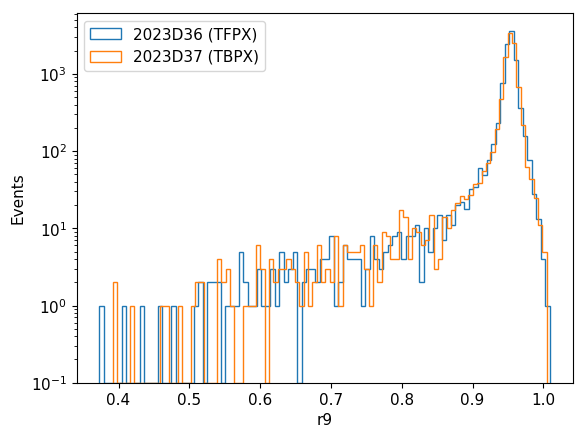

In [94]:
plt.hist(pgdf36['el1r9'].groupby('entry').mean(), bins=100, histtype='step', log=True, label='2023D36 (TFPX)');
plt.hist(pgdf37['el1r9'].groupby('entry').mean(), bins=100, histtype='step', log=True, label='2023D37 (TBPX)');
plt.xlabel('r9')
plt.ylabel('Events')
plt.legend(loc='upper left')

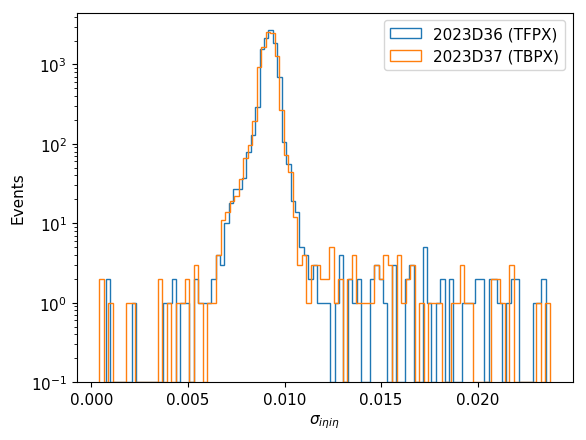

In [103]:
plt.hist(pgdf36['el1sigietaieta'].groupby('entry').mean(), bins=100, histtype='step', log=True, label='2023D36 (TFPX)');
plt.hist(pgdf37['el1sigietaieta'].groupby('entry').mean(), bins=100, histtype='step', log=True, label='2023D37 (TBPX)');
plt.xlabel('$\sigma_{i\eta i\eta}$')
plt.ylabel('Events')
plt.legend(loc='upper right')